### Figure 3: Mean and STD bias plot

In [1]:
import numpy as np
from esda.moran import Moran,Moran_Local
from libpysal.weights import lat2W
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import properscoring as ps
import warnings
from scipy import stats
# from utils.evaluation import plot_histogram,calc_peak,calc_mean
from sklearn.metrics import mean_squared_error
from math import sqrt
import xesmf as xe
warnings.filterwarnings("ignore")
sns.set_style("white")
sns.set_palette(sns.color_palette("Paired"))

/user/work/al18709/.conda/envs/aquatic/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
def plot_anomaly(inputs,cmap,plot='save',vmin=-1,vmax=1,levels = False,mode='validation'):  
        fig, ax = plt.subplots(figsize=(5, 5))  
        ax.set_title('Anomaly')
        im = ax.imshow(inputs, interpolation='nearest', vmin=vmin,vmax=vmax,extent=None,cmap=cmap)
        ax.set(xticklabels=[])
        ax.set(yticklabels=[])
        cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
        if levels:
                plt.colorbar(im, cax=cax,levels = levels) # Similar to fig.colorbar(im, cax = cax)
        else:
                plt.colorbar(im, cax=cax)
        # plt.colorbar(im)

        if plot == 'save':
                plt.savefig('figs/input_images_%s.png' % mode,bbox_inches='tight')
                plt.clf()
        else:
                plt.show()

In [3]:
model = ''
# set mode
mode = 'validation'
print(np.load('/user/home/al18709/work/tc_data_mswep/valid_X.npy').shape)


# load datasets
real = np.load('/user/home/al18709/work/dsrnngan_predictions%s/%s_real-opt.npy' % (model,mode))[0][:,:,:,0]
pred = np.load('/user/home/al18709/work/dsrnngan_predictions%s/%s_pred-opt.npy' % (model,mode))[0][:,:,:,0]

pred_cnn = np.load('/user/home/al18709/work/cnn/unet_valid.npy')
pred_dsrnngan = np.load('/user/home/al18709/work/dsrnngan_predictions/validation_pred-opt.npy')[0][:,:,:,0]
pred_vaegan = np.load('/user/home/al18709/work/vaegan/predictions/validation_pred.npy')[0][:,:,:,0]

pred_ensemble_vaegan = np.load('/user/home/al18709/work/vaegan/predictions/validation_pred.npy')[0]
pred_ensemble_gan = np.load('/user/home/al18709/work/dsrnngan_predictions%s/%s_pred-opt.npy' % (model,mode))[0]
inputs = np.load('/user/home/al18709/work/dsrnngan_predictions%s/%s_input-opt.npy' % (model,mode))[0][:,:,:,0]


# regrid inputs
grid_in = {"lon": np.linspace(0, 100, 10), "lat": np.linspace(0, 100, 10)}
grid_out = {"lon": np.linspace(0, 100, 100), "lat": np.linspace(0, 100, 100)}
regridder = xe.Regridder(grid_in, grid_out, "bilinear")
inputs_hr = regridder(inputs)


(16253, 10, 10)


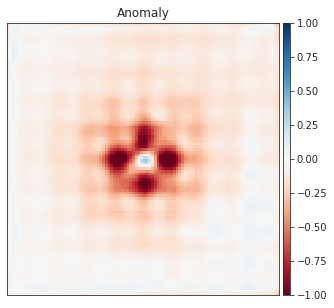

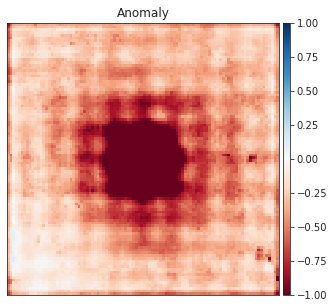

In [12]:
# calc means etc
mean_real = np.nanmean(real,axis=0)
mean_pred = np.nanmean(pred_cnn,axis=0)
mean_anom = mean_pred - mean_real
plot_anomaly(mean_anom,cmap='RdBu',plot='show')


std_real = np.nanstd(real,axis=0)
std_pred = np.nanstd(pred_cnn,axis=0)
std_anom = std_pred - std_real
plot_anomaly(std_anom,cmap = 'RdBu',plot='show')


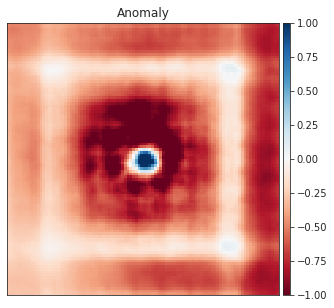

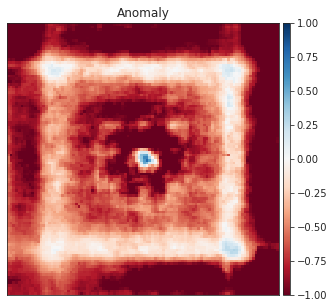

In [5]:
# calc means etc
mean_real = np.nanmean(real,axis=0)
mean_pred = np.nanmean(pred_vaegan,axis=0)
mean_anom = mean_pred - mean_real
plot_anomaly(mean_anom,cmap='RdBu',plot='show')

std_real = np.nanstd(real,axis=0)
std_pred = np.nanstd(pred_vaegan,axis=0)
std_anom = std_pred - std_real
plot_anomaly(std_anom,cmap = 'RdBu',plot='show')

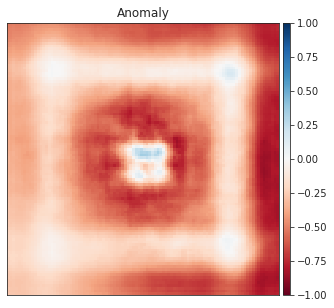

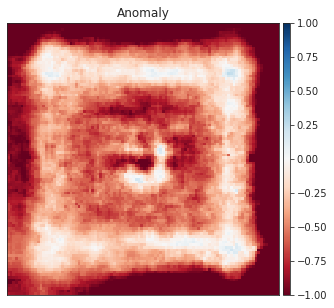

In [6]:
# calc means etc
mean_real = np.nanmean(real,axis=0)
mean_pred = np.nanmean(pred_dsrnngan,axis=0)
mean_anom = mean_pred - mean_real
plot_anomaly(mean_anom,cmap='RdBu',plot='show')

std_real = np.nanstd(real,axis=0)
std_pred = np.nanstd(pred_dsrnngan,axis=0)
std_anom = std_pred - std_real
plot_anomaly(std_anom,cmap = 'RdBu',plot='show')

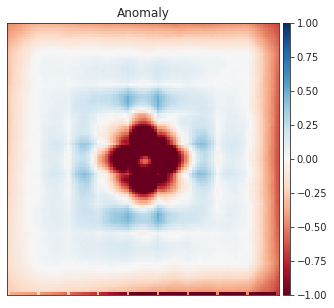

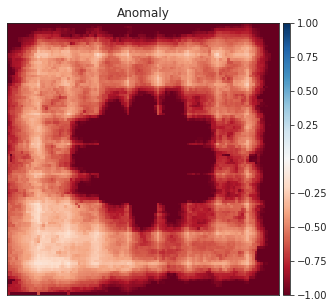

In [7]:
# calc means etc
mean_real = np.nanmean(real,axis=0)
mean_pred = np.nanmean(inputs_hr,axis=0)
mean_anom = mean_pred - mean_real
plot_anomaly(mean_anom,cmap='RdBu',plot='show')

std_real = np.nanstd(real,axis=0)
std_pred = np.nanstd(inputs_hr,axis=0)
std_anom = std_pred - std_real
plot_anomaly(std_anom,cmap = 'RdBu',plot='show')